In [1]:
ASSET = "XRPUSDT"
TARGET = "MA_7"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,0.8507,136976730.0,Extreme Fear,0.024995,0.046473,45.307315,22.522720,0.0245,0.0260,0.0259,-0.0001,0.511771,0.001543,-0.006479,0.862071,0.891464
2022-01-02,0.8586,129688032.0,Fear,0.009244,0.046456,46.415490,22.134504,0.0236,0.0295,0.0159,-0.0136,0.508931,0.001605,-0.009280,0.853300,0.893150
2022-01-03,0.8324,178618617.0,Fear,-0.030990,0.044825,43.283233,22.058970,-0.0474,0.0374,0.0001,-0.0373,0.502407,0.001551,-0.011456,0.839800,0.889764
2022-01-04,0.8228,214415744.0,Extreme Fear,-0.011600,0.038926,42.160554,22.666112,-0.1239,0.0662,0.0132,-0.0530,0.486053,0.001525,-0.011492,0.835700,0.880914
2022-01-05,0.7726,370612510.0,Extreme Fear,-0.062952,0.040992,36.787156,24.113538,-0.1811,0.1280,0.0145,-0.1135,0.468132,0.001636,-0.012187,0.829343,0.867979


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:39,465] A new study created in memory with name: no-name-35030687-4dc6-483b-b119-587291aae750


Epoch 1/86


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0470 - val_loss: 0.2040
Epoch 2/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0206 - val_loss: 0.1685
Epoch 3/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0122 - val_loss: 0.1263
Epoch 4/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0077 - val_loss: 0.1096
Epoch 5/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061 - val_loss: 0.0940
Epoch 6/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0053 - val_loss: 0.0791
Epoch 7/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042 - val_loss: 0.0714
Epoch 8/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038 - val_loss: 0.0639
Epoch 9/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0034 - val_loss: 0.0600
Epoch 10/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0031 - val_loss: 0.0526
Epoch 11/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028 - val_loss: 0.0480
Epoch 12/86
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0029 - val_l

[I 2025-05-09 19:34:03,675] Trial 0 finished with value: 0.07594369266809906 and parameters: {'units_l0': 63, 'dropout_l0': 0.38996954841077025, 'learning_rate': 0.00013131910478777584, 'batch_size': 64, 'max_epochs': 86, 'sequence_length': 46}. Best is trial 0 with value: 0.07594369266809906.


Epoch 1/51


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0091 - val_loss: 0.0253
Epoch 2/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0150
Epoch 3/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0148
Epoch 4/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0167
Epoch 5/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0188
Epoch 6/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0229
Epoch 7/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.6447e-04 - val_loss: 0.0185
Epoch 8/51
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0208
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-05-09 19:34:13,148] Trial 1 finished with value: 0.0698751489319383 and parameters: {'units_l0': 163, 'dropout_l0': 0.2791939682333966, 'learning_rate': 0.0006322519531063613, 'batch_size': 16, 'max_epochs': 51, 'sequence_length': 15}. Best is trial 1 with value: 0.0698751489319383.


Epoch 1/51


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0121 - val_loss: 0.0608
Epoch 2/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 0.0405
Epoch 3/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 0.0379
Epoch 4/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017 - val_loss: 0.0325
Epoch 5/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 0.0328
Epoch 6/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017 - val_loss: 0.0335
Epoch 7/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 0.0286
Epoch 8/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016 - val_loss: 0.0344
Epoch 9/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 0.0348
Epoch 10/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0348
Epoch 11/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0291
Epoch 12/51
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_l

[I 2025-05-09 19:34:37,828] Trial 2 finished with value: 0.13227714276700372 and parameters: {'units_l0': 116, 'dropout_l0': 0.4517922708370201, 'learning_rate': 8.260486174803366e-05, 'batch_size': 16, 'max_epochs': 51, 'sequence_length': 54}. Best is trial 1 with value: 0.0698751489319383.


Epoch 1/56


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0194 - val_loss: 0.0996
Epoch 2/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0088 - val_loss: 0.0766
Epoch 3/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0592
Epoch 4/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0498
Epoch 5/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.0431
Epoch 6/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.0373
Epoch 7/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0341
Epoch 8/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - val_loss: 0.0317
Epoch 9/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0280
Epoch 10/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 0.0253
Epoch 11/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - val_loss: 0.0246
Epoch 12/56
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_l

[I 2025-05-09 19:34:56,891] Trial 3 finished with value: 0.09303112424807954 and parameters: {'units_l0': 118, 'dropout_l0': 0.38928440349809923, 'learning_rate': 5.581639643672631e-05, 'batch_size': 32, 'max_epochs': 56, 'sequence_length': 16}. Best is trial 1 with value: 0.0698751489319383.


Epoch 1/35


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0121 - val_loss: 0.0782
Epoch 2/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0048 - val_loss: 0.0671
Epoch 3/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0032 - val_loss: 0.0629
Epoch 4/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0029 - val_loss: 0.0542
Epoch 5/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0465
Epoch 6/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0020 - val_loss: 0.0396
Epoch 7/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0018 - val_loss: 0.0362
Epoch 8/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 0.0339
Epoch 9/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0017 - val_loss: 0.0345
Epoch 10/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0020 - val_loss: 0.0315
Epoch 11/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0019 - val_loss: 0.0332
Epoch 12/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0017 - val_l

[I 2025-05-09 19:35:12,673] Trial 4 finished with value: 0.14038178306012278 and parameters: {'units_l0': 151, 'dropout_l0': 0.48080689752147354, 'learning_rate': 9.164929404309695e-05, 'batch_size': 64, 'max_epochs': 35, 'sequence_length': 42}. Best is trial 1 with value: 0.0698751489319383.


Epoch 1/99


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0164 - val_loss: 0.0471
Epoch 2/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 0.0410
Epoch 3/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 0.0359
Epoch 4/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0499
Epoch 5/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0463
Epoch 6/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0491
Epoch 7/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0478
Epoch 8/99
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018 - val_loss: 0.0444
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step


[I 2025-05-09 19:35:26,974] Trial 5 finished with value: 0.17020085461866624 and parameters: {'units_l0': 97, 'dropout_l0': 0.494463249207915, 'learning_rate': 0.00505825538122577, 'batch_size': 16, 'max_epochs': 99, 'sequence_length': 38}. Best is trial 1 with value: 0.0698751489319383.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0319 - val_loss: 0.0327
Epoch 2/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.0287
Epoch 3/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0243
Epoch 4/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6288e-04 - val_loss: 0.0176
Epoch 5/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.1918e-04 - val_loss: 0.0153
Epoch 6/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.2213e-04 - val_loss: 0.0144
Epoch 7/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.8128e-04 - val_loss: 0.0118
Epoch 8/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.3600e-04 - val_loss: 0.0125
Epoch 9/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4708e-04 - val_loss: 0.0129
Epoch 10/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.8832e-04 - val_loss: 0.0112
Epoch 11/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3468e-04 - val_loss: 0.0114
Epoch 12/18
27/27 ━━━━━━━━━━━━━

[I 2025-05-09 19:35:43,909] Trial 6 finished with value: 0.052685171776729545 and parameters: {'units_l0': 72, 'dropout_l0': 0.14721255014844864, 'learning_rate': 0.0008758108611985366, 'batch_size': 32, 'max_epochs': 18, 'sequence_length': 25}. Best is trial 6 with value: 0.052685171776729545.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0083 - val_loss: 0.0153
Epoch 2/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7390e-04 - val_loss: 0.0094
Epoch 3/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9969e-04 - val_loss: 0.0072
Epoch 4/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2526e-04 - val_loss: 0.0092
Epoch 5/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3747e-04 - val_loss: 0.0047
Epoch 6/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.3551e-04 - val_loss: 0.0063
Epoch 7/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5348e-04 - val_loss: 0.0063
Epoch 8/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5015e-04 - val_loss: 0.0090
Epoch 9/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6598e-04 - val_loss: 0.0068
Epoch 10/82
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3984e-04 - val_loss: 0.0077
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-05-09 19:35:56,795] Trial 7 finished with value: 0.022147370140660524 and parameters: {'units_l0': 71, 'dropout_l0': 0.11191699998204713, 'learning_rate': 0.0017388874194030287, 'batch_size': 16, 'max_epochs': 82, 'sequence_length': 23}. Best is trial 7 with value: 0.022147370140660524.


Epoch 1/64


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0077 - val_loss: 0.0431
Epoch 2/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0166
Epoch 3/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.5865e-04 - val_loss: 0.0078
Epoch 4/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.7999e-04 - val_loss: 0.0044
Epoch 5/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7063e-04 - val_loss: 0.0037
Epoch 6/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6525e-04 - val_loss: 0.0039
Epoch 7/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3219e-04 - val_loss: 0.0035
Epoch 8/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7938e-04 - val_loss: 0.0034
Epoch 9/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2783e-04 - val_loss: 0.0031
Epoch 10/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0215e-04 - val_loss: 0.0027
Epoch 11/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0323e-04 - val_loss: 0.0029
Epoch 12/64
54/54 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:36:28,850] Trial 8 finished with value: 0.010923215695599744 and parameters: {'units_l0': 72, 'dropout_l0': 0.014946446468513896, 'learning_rate': 0.0002227583790558174, 'batch_size': 16, 'max_epochs': 64, 'sequence_length': 36}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0391 - val_loss: 0.1806
Epoch 2/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0343 - val_loss: 0.1652
Epoch 3/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0335 - val_loss: 0.1535
Epoch 4/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0265 - val_loss: 0.1430
Epoch 5/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0229 - val_loss: 0.1347
Epoch 6/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0239 - val_loss: 0.1277
Epoch 7/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0209 - val_loss: 0.1224
Epoch 8/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0205 - val_loss: 0.1180
Epoch 9/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0193 - val_loss: 0.1152
Epoch 10/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - val_loss: 0.1133
Epoch 11/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0190 - val_loss: 0.1106
Epoch 12/38
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0

[I 2025-05-09 19:36:55,016] Trial 9 finished with value: 0.35925315987057616 and parameters: {'units_l0': 54, 'dropout_l0': 0.4111630450758519, 'learning_rate': 1.7239904955983283e-05, 'batch_size': 64, 'max_epochs': 38, 'sequence_length': 49}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0074 - val_loss: 0.1096
Epoch 2/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0049 - val_loss: 0.0944
Epoch 3/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0034 - val_loss: 0.0827
Epoch 4/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0030 - val_loss: 0.0733
Epoch 5/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022 - val_loss: 0.0656
Epoch 6/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - val_loss: 0.0575
Epoch 7/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 0.0506
Epoch 8/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - val_loss: 0.0440
Epoch 9/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0390
Epoch 10/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.9880e-04 - val_loss: 0.0349
Epoch 11/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.3997e-04 - val_loss: 0.0311
Epoch 12/74
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - l

[I 2025-05-09 19:38:40,510] Trial 10 finished with value: 0.028755686171191727 and parameters: {'units_l0': 199, 'dropout_l0': 0.006400110786753788, 'learning_rate': 1.0434937811541523e-05, 'batch_size': 16, 'max_epochs': 74, 'sequence_length': 33}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0223 - val_loss: 0.0290
Epoch 2/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4074e-04 - val_loss: 0.0142
Epoch 3/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3947e-04 - val_loss: 0.0140
Epoch 4/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3625e-04 - val_loss: 0.0120
Epoch 5/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0904e-04 - val_loss: 0.0106
Epoch 6/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.4976e-04 - val_loss: 0.0103
Epoch 7/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9939e-04 - val_loss: 0.0112
Epoch 8/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9514e-04 - val_loss: 0.0123
Epoch 9/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6947e-04 - val_loss: 0.0097
Epoch 10/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2794e-04 - val_loss: 0.0095
Epoch 11/76
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0724e-04 - val_loss: 0.0095
Epoch 12/76
54/54 ━━━━━

[I 2025-05-09 19:38:56,479] Trial 11 finished with value: 0.04496334229807564 and parameters: {'units_l0': 88, 'dropout_l0': 0.044529467694295735, 'learning_rate': 0.003464478323661155, 'batch_size': 16, 'max_epochs': 76, 'sequence_length': 26}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0101 - val_loss: 0.0160
Epoch 2/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8633e-04 - val_loss: 0.0108
Epoch 3/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.2417e-04 - val_loss: 0.0117
Epoch 4/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.0466e-04 - val_loss: 0.0098
Epoch 5/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5589e-04 - val_loss: 0.0122
Epoch 6/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7972e-04 - val_loss: 0.0149
Epoch 7/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8203e-04 - val_loss: 0.0177
Epoch 8/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1806e-04 - val_loss: 0.0174
Epoch 9/68
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0731e-04 - val_loss: 0.0179
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-05-09 19:39:09,993] Trial 12 finished with value: 0.046619649072029846 and parameters: {'units_l0': 89, 'dropout_l0': 0.12666729291780243, 'learning_rate': 0.0015456574431998162, 'batch_size': 16, 'max_epochs': 68, 'sequence_length': 29}. Best is trial 8 with value: 0.010923215695599744.


Epoch 1/92


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0284 - val_loss: 0.0648
Epoch 2/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0026 - val_loss: 0.0544
Epoch 3/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0365
Epoch 4/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0290
Epoch 5/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.4166e-04 - val_loss: 0.0210
Epoch 6/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9325e-04 - val_loss: 0.0168
Epoch 7/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7965e-04 - val_loss: 0.0147
Epoch 8/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.7956e-04 - val_loss: 0.0143
Epoch 9/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.3674e-04 - val_loss: 0.0120
Epoch 10/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.6483e-04 - val_loss: 0.0105
Epoch 11/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9206e-04 - val_loss: 0.0105
Epoch 12/92
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms

[I 2025-05-09 19:39:46,596] Trial 13 finished with value: 0.03972860353945642 and parameters: {'units_l0': 53, 'dropout_l0': 0.10148824728235575, 'learning_rate': 0.00029410499250730296, 'batch_size': 16, 'max_epochs': 92, 'sequence_length': 60}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0267 - val_loss: 0.0499
Epoch 2/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027 - val_loss: 0.0241
Epoch 3/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0129
Epoch 4/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 0.0106
Epoch 5/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0096
Epoch 6/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1469e-04 - val_loss: 0.0088
Epoch 7/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7210e-04 - val_loss: 0.0093
Epoch 8/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0083
Epoch 9/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6469e-04 - val_loss: 0.0133
Epoch 10/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2136e-04 - val_loss: 0.0113
Epoch 11/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4926e-04 - val_loss: 0.0133
Epoch 12/65
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

[I 2025-05-09 19:40:01,631] Trial 14 finished with value: 0.039135606784107296 and parameters: {'units_l0': 78, 'dropout_l0': 0.20969751753153215, 'learning_rate': 0.00036197669620511506, 'batch_size': 16, 'max_epochs': 65, 'sequence_length': 10}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.1343 - val_loss: 0.0559
Epoch 2/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0441
Epoch 3/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6085e-04 - val_loss: 0.0230
Epoch 4/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0431e-04 - val_loss: 0.0133
Epoch 5/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8068e-04 - val_loss: 0.0118
Epoch 6/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7583e-04 - val_loss: 0.0115
Epoch 7/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6668e-04 - val_loss: 0.0106
Epoch 8/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.1962e-04 - val_loss: 0.0093
Epoch 9/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.5933e-04 - val_loss: 0.0107
Epoch 10/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4860e-04 - val_loss: 0.0108
Epoch 11/83
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.6465e-04 - val_loss: 0.0092
Epoch 12/83
28/28 ━━━━━━━━━

[I 2025-05-09 19:40:21,227] Trial 15 finished with value: 0.0429978458797845 and parameters: {'units_l0': 103, 'dropout_l0': 0.0630542344693005, 'learning_rate': 0.008409990969172606, 'batch_size': 32, 'max_epochs': 83, 'sequence_length': 20}. Best is trial 8 with value: 0.010923215695599744.


Epoch 1/60


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0105 - val_loss: 0.0138
Epoch 2/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.6705e-04 - val_loss: 0.0076
Epoch 3/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.9170e-04 - val_loss: 0.0225
Epoch 4/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0141
Epoch 5/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.6792e-04 - val_loss: 0.0148
Epoch 6/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7340e-04 - val_loss: 0.0196
Epoch 7/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5921e-04 - val_loss: 0.0210
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


[I 2025-05-09 19:40:34,645] Trial 16 finished with value: 0.035952399795825214 and parameters: {'units_l0': 138, 'dropout_l0': 0.20571743882681276, 'learning_rate': 0.002093897332129018, 'batch_size': 16, 'max_epochs': 60, 'sequence_length': 37}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0157 - val_loss: 0.0717
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0335
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0178
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0141
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0157
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0187
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0133
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0203
Epoch 9/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 0.0171
Epoch 10/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0156
Epoch 11/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0154
Epoch 12/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

[I 2025-05-09 19:40:51,553] Trial 17 finished with value: 0.06280524161820539 and parameters: {'units_l0': 73, 'dropout_l0': 0.30468723130679576, 'learning_rate': 0.0002745526596863087, 'batch_size': 16, 'max_epochs': 40, 'sequence_length': 30}. Best is trial 8 with value: 0.010923215695599744.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0166 - val_loss: 0.0601
Epoch 2/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0024 - val_loss: 0.0290
Epoch 3/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.0472e-04 - val_loss: 0.0092
Epoch 4/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.3083e-04 - val_loss: 0.0038
Epoch 5/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.3350e-04 - val_loss: 0.0040
Epoch 6/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.1362e-04 - val_loss: 0.0040
Epoch 7/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 9.6164e-05 - val_loss: 0.0037
Epoch 8/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.6964e-05 - val_loss: 0.0030
Epoch 9/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 8.1222e-05 - val_loss: 0.0030
Epoch 10/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.6416e-05 - val_loss: 0.0034
Epoch 11/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.8197e-05 - val_loss: 0.0030
Epoch 12/78
14/14 ━━━━━━━━━

[I 2025-05-09 19:41:10,246] Trial 18 finished with value: 0.008701227570075345 and parameters: {'units_l0': 177, 'dropout_l0': 0.008670041622431693, 'learning_rate': 0.0010776327857376508, 'batch_size': 64, 'max_epochs': 78, 'sequence_length': 22}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/23


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0162 - val_loss: 0.0548
Epoch 2/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0031 - val_loss: 0.0276
Epoch 3/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0010 - val_loss: 0.0150
Epoch 4/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 3.4931e-04 - val_loss: 0.0089
Epoch 5/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.6737e-04 - val_loss: 0.0074
Epoch 6/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.3394e-04 - val_loss: 0.0070
Epoch 7/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.1816e-04 - val_loss: 0.0065
Epoch 8/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 7.8057e-05 - val_loss: 0.0072
Epoch 9/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.3919e-05 - val_loss: 0.0060
Epoch 10/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 7.5582e-05 - val_loss: 0.0058
Epoch 11/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 6.1664e-05 - val_loss: 0.0054
Epoch 12/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

[I 2025-05-09 19:41:38,372] Trial 19 finished with value: 0.016517447065462387 and parameters: {'units_l0': 188, 'dropout_l0': 0.006809483157271406, 'learning_rate': 0.0007698033106687708, 'batch_size': 64, 'max_epochs': 23, 'sequence_length': 40}. Best is trial 18 with value: 0.008701227570075345.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0078 - val_loss: 0.1251
Epoch 2/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0046 - val_loss: 0.1063
Epoch 3/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0034 - val_loss: 0.0891
Epoch 4/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0030 - val_loss: 0.0770
Epoch 5/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0025 - val_loss: 0.0622
Epoch 6/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0019 - val_loss: 0.0556
Epoch 7/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0016 - val_loss: 0.0466
Epoch 8/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0017 - val_loss: 0.0409
Epoch 9/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0014 - val_loss: 0.0370
Epoch 10/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0012 - val_loss: 0.0326
Epoch 11/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 9.7884e-04 - val_loss: 0.0293
Epoch 12/71
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss:

[I 2025-05-09 19:42:19,571] Trial 20 finished with value: 0.05615741236215007 and parameters: {'units_l0': 173, 'dropout_l0': 0.19005713904088384, 'learning_rate': 4.183363469064641e-05, 'batch_size': 64, 'max_epochs': 71, 'sequence_length': 34}. Best is trial 18 with value: 0.008701227570075345.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0086 - val_loss: 0.0536
Epoch 2/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0019 - val_loss: 0.0212
Epoch 3/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.8716e-04 - val_loss: 0.0080
Epoch 4/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9468e-04 - val_loss: 0.0063
Epoch 5/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 9.8601e-05 - val_loss: 0.0059
Epoch 6/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 9.6682e-05 - val_loss: 0.0053
Epoch 7/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.3767e-05 - val_loss: 0.0055
Epoch 8/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.3993e-05 - val_loss: 0.0057
Epoch 9/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 8.7589e-05 - val_loss: 0.0044
Epoch 10/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 4.7895e-05 - val_loss: 0.0042
Epoch 11/19
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 6.1624e-05 - val_loss: 0.0046
Epoch 12/19
14/14 ━━━━━━━━

[I 2025-05-09 19:42:48,017] Trial 21 finished with value: 0.0166175435890191 and parameters: {'units_l0': 198, 'dropout_l0': 0.00856046057039793, 'learning_rate': 0.0007411492803668401, 'batch_size': 64, 'max_epochs': 19, 'sequence_length': 42}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/10


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0117 - val_loss: 0.1203
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0048 - val_loss: 0.0686
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0019 - val_loss: 0.0416
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0013 - val_loss: 0.0301
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 7.7907e-04 - val_loss: 0.0233
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 5.4504e-04 - val_loss: 0.0189
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 5.6701e-04 - val_loss: 0.0172
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.0846e-04 - val_loss: 0.0151
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.5747e-04 - val_loss: 0.0148
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.6829e-04 - val_loss: 0.0152
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


[I 2025-05-09 19:43:04,310] Trial 22 finished with value: 0.0702720921729749 and parameters: {'units_l0': 185, 'dropout_l0': 0.053998464971270324, 'learning_rate': 0.00016707739286383477, 'batch_size': 64, 'max_epochs': 10, 'sequence_length': 42}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/28


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0066 - val_loss: 0.0640
Epoch 2/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016 - val_loss: 0.0186
Epoch 3/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.7809e-04 - val_loss: 0.0147
Epoch 4/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.6886e-04 - val_loss: 0.0094
Epoch 5/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.5081e-04 - val_loss: 0.0103
Epoch 6/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 8.2618e-05 - val_loss: 0.0088
Epoch 7/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.7716e-05 - val_loss: 0.0081
Epoch 8/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 5.6024e-05 - val_loss: 0.0076
Epoch 9/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4.2252e-05 - val_loss: 0.0075
Epoch 10/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.8582e-05 - val_loss: 0.0073
Epoch 11/28
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 4.2555e-05 - val_loss: 0.0065
Epoch 12/28
14/14 ━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:43:32,270] Trial 23 finished with value: 0.023988311546840883 and parameters: {'units_l0': 139, 'dropout_l0': 0.0007125510136661052, 'learning_rate': 0.000495753771147481, 'batch_size': 64, 'max_epochs': 28, 'sequence_length': 51}. Best is trial 18 with value: 0.008701227570075345.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0363 - val_loss: 0.0322
Epoch 2/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0035 - val_loss: 0.0333
Epoch 3/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0014 - val_loss: 0.0180
Epoch 4/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.0913e-04 - val_loss: 0.0118
Epoch 5/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.5928e-04 - val_loss: 0.0084
Epoch 6/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.1683e-04 - val_loss: 0.0081
Epoch 7/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.2619e-04 - val_loss: 0.0077
Epoch 8/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.6275e-04 - val_loss: 0.0082
Epoch 9/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.9309e-04 - val_loss: 0.0077
Epoch 10/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.2463e-04 - val_loss: 0.0072
Epoch 11/45
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.0600e-04 - val_loss: 0.0063
Epoch 12/45
14/14 ━━━━━━━━━━━━

[I 2025-05-09 19:43:52,702] Trial 24 finished with value: 0.027584772156668793 and parameters: {'units_l0': 173, 'dropout_l0': 0.06176914407614546, 'learning_rate': 0.0010729415236782557, 'batch_size': 64, 'max_epochs': 45, 'sequence_length': 31}. Best is trial 18 with value: 0.008701227570075345.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0095 - val_loss: 0.0504
Epoch 2/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0032 - val_loss: 0.0238
Epoch 3/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0016 - val_loss: 0.0165
Epoch 4/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0012 - val_loss: 0.0139
Epoch 5/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.4683e-04 - val_loss: 0.0113
Epoch 6/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.6861e-04 - val_loss: 0.0090
Epoch 7/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 5.0676e-04 - val_loss: 0.0068
Epoch 8/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.6592e-04 - val_loss: 0.0065
Epoch 9/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3297e-04 - val_loss: 0.0071
Epoch 10/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 5.2257e-04 - val_loss: 0.0070
Epoch 11/64
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.3410e-04 - val_loss: 0.0074
Epoch 12/64
14/14 ━━━━━━━━━━━━━━━━

[I 2025-05-09 19:44:06,958] Trial 25 finished with value: 0.030917891532359198 and parameters: {'units_l0': 185, 'dropout_l0': 0.08931107767073937, 'learning_rate': 0.0001960212736221208, 'batch_size': 64, 'max_epochs': 64, 'sequence_length': 37}. Best is trial 18 with value: 0.008701227570075345.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0287 - val_loss: 0.0730
Epoch 2/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 0.0395
Epoch 3/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0016 - val_loss: 0.0265
Epoch 4/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.6168e-04 - val_loss: 0.0166
Epoch 5/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.3746e-04 - val_loss: 0.0144
Epoch 6/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 5.3787e-04 - val_loss: 0.0122
Epoch 7/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.3892e-04 - val_loss: 0.0122
Epoch 8/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.0365e-04 - val_loss: 0.0143
Epoch 9/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.8702e-04 - val_loss: 0.0141
Epoch 10/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.7206e-04 - val_loss: 0.0133
Epoch 11/29
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.9810e-04 - val_loss: 0.0134
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67m

[I 2025-05-09 19:44:19,740] Trial 26 finished with value: 0.0578062880821207 and parameters: {'units_l0': 135, 'dropout_l0': 0.14319661700699254, 'learning_rate': 0.0029302006967503657, 'batch_size': 64, 'max_epochs': 29, 'sequence_length': 41}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/78


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0136 - val_loss: 0.0585
Epoch 2/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - val_loss: 0.0213
Epoch 3/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.0394e-04 - val_loss: 0.0136
Epoch 4/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.6350e-04 - val_loss: 0.0115
Epoch 5/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.1876e-04 - val_loss: 0.0112
Epoch 6/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.9974e-04 - val_loss: 0.0101
Epoch 7/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.6548e-04 - val_loss: 0.0102
Epoch 8/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.2074e-04 - val_loss: 0.0088
Epoch 9/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.2868e-04 - val_loss: 0.0079
Epoch 10/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.4047e-04 - val_loss: 0.0080
Epoch 11/78
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.7205e-04 - val_loss: 0.0091
Epoch 12/78
27/27 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:44:49,342] Trial 27 finished with value: 0.02746026264762298 and parameters: {'units_l0': 157, 'dropout_l0': 0.02758231163816559, 'learning_rate': 0.0004633581640360795, 'batch_size': 32, 'max_epochs': 78, 'sequence_length': 47}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/88


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.0108 - val_loss: 0.0364
Epoch 2/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - val_loss: 0.0224
Epoch 3/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0016 - val_loss: 0.0158
Epoch 4/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0013 - val_loss: 0.0170
Epoch 5/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0012 - val_loss: 0.0167
Epoch 6/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012 - val_loss: 0.0187
Epoch 7/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 0.0193
Epoch 8/88
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0011 - val_loss: 0.0181
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


[I 2025-05-09 19:45:01,745] Trial 28 finished with value: 0.07475936484446212 and parameters: {'units_l0': 185, 'dropout_l0': 0.32968139990487616, 'learning_rate': 0.0011612116609320063, 'batch_size': 64, 'max_epochs': 88, 'sequence_length': 22}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/58


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0080 - val_loss: 0.0720
Epoch 2/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033 - val_loss: 0.0452
Epoch 3/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - val_loss: 0.0327
Epoch 4/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.9582e-04 - val_loss: 0.0209
Epoch 5/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.5303e-04 - val_loss: 0.0145
Epoch 6/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.7436e-04 - val_loss: 0.0097
Epoch 7/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.1847e-04 - val_loss: 0.0087
Epoch 8/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.8897e-04 - val_loss: 0.0075
Epoch 9/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.4763e-04 - val_loss: 0.0074
Epoch 10/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.7622e-04 - val_loss: 0.0057
Epoch 11/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.9088e-04 - val_loss: 0.0070
Epoch 12/58
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:45:16,372] Trial 29 finished with value: 0.022823986976956413 and parameters: {'units_l0': 171, 'dropout_l0': 0.08490294493754827, 'learning_rate': 0.00022508241628072233, 'batch_size': 64, 'max_epochs': 58, 'sequence_length': 18}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/46


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0086 - val_loss: 0.0908
Epoch 2/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0034 - val_loss: 0.0555
Epoch 3/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024 - val_loss: 0.0368
Epoch 4/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0016 - val_loss: 0.0280
Epoch 5/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011 - val_loss: 0.0228
Epoch 6/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.0393e-04 - val_loss: 0.0202
Epoch 7/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.4183e-04 - val_loss: 0.0167
Epoch 8/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.1505e-04 - val_loss: 0.0156
Epoch 9/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.1844e-04 - val_loss: 0.0125
Epoch 10/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 6.2622e-04 - val_loss: 0.0138
Epoch 11/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.8927e-04 - val_loss: 0.0142
Epoch 12/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/ste

[I 2025-05-09 19:45:26,327] Trial 30 finished with value: 0.059101002854025676 and parameters: {'units_l0': 148, 'dropout_l0': 0.15582708773653628, 'learning_rate': 0.00012212282255803596, 'batch_size': 64, 'max_epochs': 46, 'sequence_length': 27}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/17


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0155 - val_loss: 0.0486
Epoch 2/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0026 - val_loss: 0.0231
Epoch 3/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.6700e-04 - val_loss: 0.0179
Epoch 4/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 3.4713e-04 - val_loss: 0.0134
Epoch 5/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.2676e-04 - val_loss: 0.0126
Epoch 6/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.6740e-04 - val_loss: 0.0133
Epoch 7/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.1103e-04 - val_loss: 0.0111
Epoch 8/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.4698e-04 - val_loss: 0.0108
Epoch 9/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.6386e-04 - val_loss: 0.0101
Epoch 10/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.1397e-04 - val_loss: 0.0115
Epoch 11/17
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.3004e-04 - val_loss: 0.0100
Epoch 12/17
14/14 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:45:45,166] Trial 31 finished with value: 0.03234749541046507 and parameters: {'units_l0': 194, 'dropout_l0': 0.025442498254090888, 'learning_rate': 0.0006924249646336074, 'batch_size': 64, 'max_epochs': 17, 'sequence_length': 45}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/23


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0092 - val_loss: 0.0442
Epoch 2/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0013 - val_loss: 0.0109
Epoch 3/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3.5332e-04 - val_loss: 0.0057
Epoch 4/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.6646e-04 - val_loss: 0.0062
Epoch 5/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.2795e-05 - val_loss: 0.0058
Epoch 6/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.9474e-05 - val_loss: 0.0051
Epoch 7/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.3806e-05 - val_loss: 0.0049
Epoch 8/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 2.7973e-05 - val_loss: 0.0052
Epoch 9/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 2.4117e-05 - val_loss: 0.0050
Epoch 10/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.9689e-05 - val_loss: 0.0048
Epoch 11/23
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.0329e-05 - val_loss: 0.0044
Epoch 12/23
14/14 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:46:04,624] Trial 32 finished with value: 0.01275618841270529 and parameters: {'units_l0': 200, 'dropout_l0': 0.00023419757658083018, 'learning_rate': 0.0007027655766805534, 'batch_size': 64, 'max_epochs': 23, 'sequence_length': 40}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/27


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0038 - val_loss: 0.0317
Epoch 2/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.5763e-04 - val_loss: 0.0141
Epoch 3/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.5782e-04 - val_loss: 0.0055
Epoch 4/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.9264e-04 - val_loss: 0.0081
Epoch 5/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.2954e-04 - val_loss: 0.0089
Epoch 6/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.6328e-04 - val_loss: 0.0096
Epoch 7/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.0387e-04 - val_loss: 0.0087
Epoch 8/27
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.9206e-04 - val_loss: 0.0064
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2025-05-09 19:46:11,130] Trial 33 finished with value: 0.0260636980159156 and parameters: {'units_l0': 163, 'dropout_l0': 0.040006992084100475, 'learning_rate': 0.000451756066525323, 'batch_size': 64, 'max_epochs': 27, 'sequence_length': 39}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/52


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0377 - val_loss: 0.0647
Epoch 2/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035 - val_loss: 0.0411
Epoch 3/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019 - val_loss: 0.0345
Epoch 4/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.4090e-04 - val_loss: 0.0218
Epoch 5/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 5.6080e-04 - val_loss: 0.0125
Epoch 6/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.5769e-04 - val_loss: 0.0101
Epoch 7/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.8914e-04 - val_loss: 0.0108
Epoch 8/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.9938e-04 - val_loss: 0.0097
Epoch 9/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.3072e-04 - val_loss: 0.0099
Epoch 10/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.9834e-04 - val_loss: 0.0088
Epoch 11/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.8759e-04 - val_loss: 0.0097
Epoch 12/52
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 

[I 2025-05-09 19:46:24,753] Trial 34 finished with value: 0.037102353746037396 and parameters: {'units_l0': 190, 'dropout_l0': 0.08242174309382475, 'learning_rate': 0.0013150482994047305, 'batch_size': 64, 'max_epochs': 52, 'sequence_length': 34}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/11


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0071 - val_loss: 0.0305
Epoch 2/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.2904e-04 - val_loss: 0.0108
Epoch 3/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.9252e-04 - val_loss: 0.0103
Epoch 4/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 9.9805e-05 - val_loss: 0.0083
Epoch 5/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.9805e-05 - val_loss: 0.0076
Epoch 6/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.9100e-05 - val_loss: 0.0064
Epoch 7/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.6900e-05 - val_loss: 0.0067
Epoch 8/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.7882e-05 - val_loss: 0.0055
Epoch 9/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.6692e-05 - val_loss: 0.0049
Epoch 10/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.7097e-05 - val_loss: 0.0052
Epoch 11/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.2100e-05 - val_loss: 0.0056
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/s

[I 2025-05-09 19:46:35,674] Trial 35 finished with value: 0.023263526477561188 and parameters: {'units_l0': 178, 'dropout_l0': 0.004925910115857145, 'learning_rate': 0.0006521923904717882, 'batch_size': 32, 'max_epochs': 11, 'sequence_length': 46}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/22


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0314 - val_loss: 0.0596
Epoch 2/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0305
Epoch 3/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0212
Epoch 4/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0167
Epoch 5/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2940e-04 - val_loss: 0.0142
Epoch 6/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0177
Epoch 7/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9475e-04 - val_loss: 0.0187
Epoch 8/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0435e-04 - val_loss: 0.0173
Epoch 9/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 0.0161
Epoch 10/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7205e-04 - val_loss: 0.0179
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-05-09 19:46:39,721] Trial 36 finished with value: 0.06704729058662455 and parameters: {'units_l0': 122, 'dropout_l0': 0.23691491015117194, 'learning_rate': 0.002754033797639749, 'batch_size': 64, 'max_epochs': 22, 'sequence_length': 14}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0316 - val_loss: 0.1384
Epoch 2/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0084 - val_loss: 0.1138
Epoch 3/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0074 - val_loss: 0.1181
Epoch 4/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0050 - val_loss: 0.1162
Epoch 5/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0045 - val_loss: 0.1081
Epoch 6/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0043 - val_loss: 0.1015
Epoch 7/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0034 - val_loss: 0.0963
Epoch 8/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0031 - val_loss: 0.0890
Epoch 9/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0029 - val_loss: 0.0840
Epoch 10/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0026 - val_loss: 0.0781
Epoch 11/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0022 - val_loss: 0.0747
Epoch 12/32
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - val_l

[I 2025-05-09 19:46:59,641] Trial 37 finished with value: 0.10204513866440237 and parameters: {'units_l0': 165, 'dropout_l0': 0.05811695302381314, 'learning_rate': 4.780346864723475e-05, 'batch_size': 64, 'max_epochs': 32, 'sequence_length': 52}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/100


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042 - val_loss: 0.0523
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0440
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0335
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2273e-04 - val_loss: 0.0290
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.8451e-04 - val_loss: 0.0234
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5211e-04 - val_loss: 0.0213
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6254e-04 - val_loss: 0.0196
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6202e-04 - val_loss: 0.0183
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7027e-04 - val_loss: 0.0171
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8137e-04 - val_loss: 0.0158
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0725e-04 - val_loss: 0.0158
Epoch 12/100
27/27 ━━━━━━━━━━━━━

[I 2025-05-09 19:47:20,010] Trial 38 finished with value: 0.034666830716646904 and parameters: {'units_l0': 109, 'dropout_l0': 0.02621233900103396, 'learning_rate': 8.611982841879075e-05, 'batch_size': 32, 'max_epochs': 100, 'sequence_length': 57}. Best is trial 18 with value: 0.008701227570075345.


Epoch 1/46


C:\Users\IC2594\AppData\Local\Temp\ipykernel_6772\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0131 - val_loss: 0.0371
Epoch 2/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027 - val_loss: 0.0315
Epoch 3/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.0574e-04 - val_loss: 0.0194
Epoch 4/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.2857e-04 - val_loss: 0.0125
Epoch 5/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.9000e-04 - val_loss: 0.0111
Epoch 6/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.2408e-04 - val_loss: 0.0128
Epoch 7/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.4117e-04 - val_loss: 0.0127
Epoch 8/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.4534e-04 - val_loss: 0.0138
Epoch 9/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.3169e-04 - val_loss: 0.0089
Epoch 10/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7664e-04 - val_loss: 0.0089
Epoch 11/46
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.2583e-04 - val_loss: 0.0163
Epoch 12/46
14/14 ━━━━━━━━━━━━━━━━━━━━

[I 2025-05-09 19:47:25,845] Trial 39 finished with value: 0.042054951608478185 and parameters: {'units_l0': 181, 'dropout_l0': 0.1698327980700966, 'learning_rate': 0.0009428783466922608, 'batch_size': 64, 'max_epochs': 46, 'sequence_length': 36}. Best is trial 18 with value: 0.008701227570075345.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
18,177,0.008670,0.001078,64,78,22,0.008701
8,72,0.014946,0.000223,16,64,36,0.010923
32,200,0.000234,0.000703,64,23,40,0.012756
19,188,0.006809,0.000770,64,23,40,0.016517
21,198,0.008560,0.000741,64,19,42,0.016618
7,71,0.111917,0.001739,16,82,23,0.022147
29,171,0.084903,0.000225,64,58,18,0.022824
35,178,0.004926,0.000652,32,11,46,0.023264
23,139,0.000713,0.000496,64,28,51,0.023988
33,163,0.040007,0.000452,64,27,39,0.026064


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0109 - val_loss: 0.0348
Epoch 2/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0187
Epoch 3/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0083
Epoch 4/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5800e-04 - val_loss: 0.0039
Epoch 5/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0065e-04 - val_loss: 0.0046
Epoch 6/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1703e-04 - val_loss: 0.0040
Epoch 7/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5412e-05 - val_loss: 0.0039
Epoch 8/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7299e-05 - val_loss: 0.0034
Epoch 9/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1759e-05 - val_loss: 0.0029
Epoch 10/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7214e-05 - val_loss: 0.0029
Epoch 11/78
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4020e-05 - val_loss: 0.0028
Epoch 12/78
14/14 ━━━━━━━━━━━━━

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_val_inv, y_pred_inv)
mse_naive = mean_squared_error(y_val_inv, naive_close)
mse_naive_target = mean_squared_error(y_val_inv, naive_target)

# Print MSE
print(f"MSE (Predicted Target vs. Actual Target): {mse:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Target): {mse_naive:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.9f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Shapes:
y_pred: (210,), y_val: (210,)
Naive benchmark shape: (210,)
MSE (Predicted Target vs. Actual Target): 0.0054
MSE (Naive Model - Today's Close as Tomorrow's Target): 0.0069
MSE (Naive Model - Today's Target as Tomorrow's Target): 0.000968097


In [8]:
df.to_csv("tmp_df_data.csv")

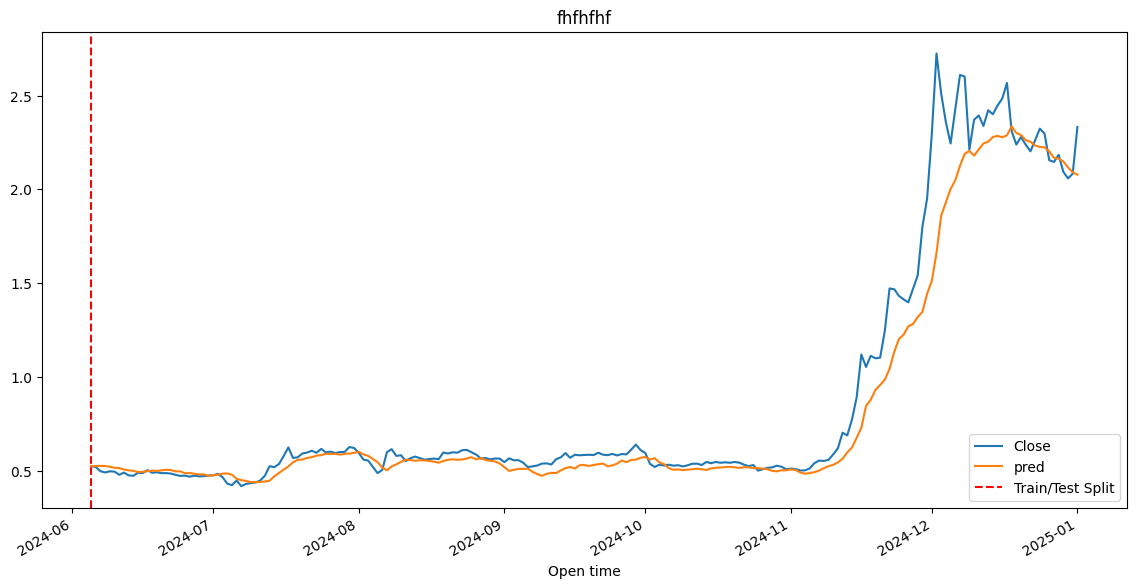

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

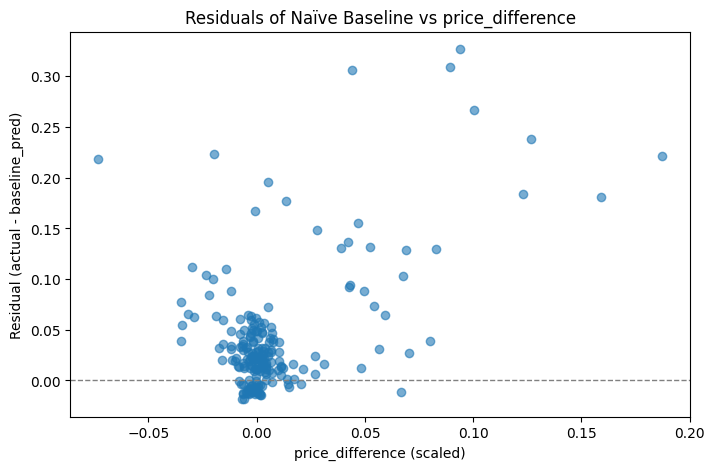

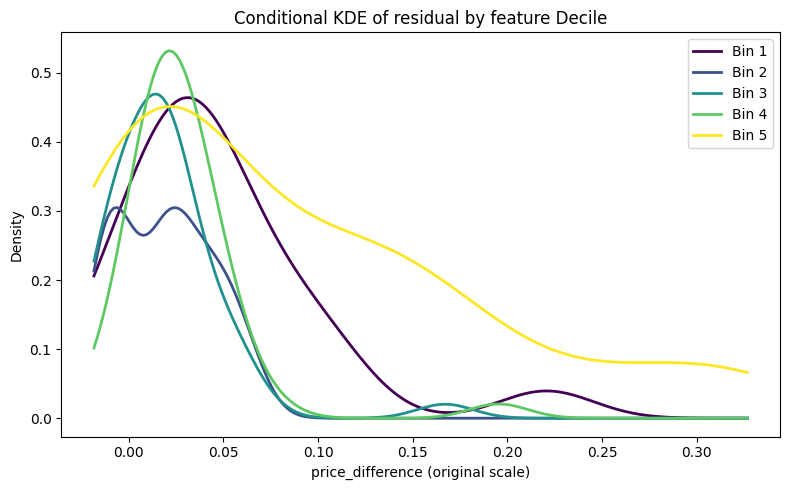

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)